In [1]:
import torch
import torch.nn as nn
import torch.nn.utils as ut
from torch.optim.optimizer import Optimizer, required

In [2]:
from collections import Iterable, deque
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from bnelearn.strategy import NeuralNetStrategy, TruthfulStrategy
from bnelearn.bidder import Bidder
from bnelearn.mechanism import FirstPriceSealedBidAuction, VickreyAuction
from bnelearn.optimizer import ES
from bnelearn.environment import Environment

In [4]:
hidden_layer = 10
batch_size = 5
u_lo = 0
u_hi = 10
n_players = 2
n_items = 1

epochs = 1

In [5]:
model = NeuralNetStrategy(2, hidden_layer).cuda()

In [6]:
mechanism = FirstPriceSealedBidAuction(cuda=True)

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=.01)

In [8]:
p1 =Bidder.uniform(u_lo,u_hi, model, batch_size = batch_size, n_players=2)

In [9]:
p2 = Bidder.uniform(u_lo,u_hi, model, batch_size = batch_size, n_players=2)

In [10]:
p1.draw_valuations_(), p2.draw_valuations_();

In [11]:
b1 = p1.get_action()
b2 = p2.get_action()

In [12]:
for epoch in range(epochs):
    # draw new valuations and bids
    p1.draw_valuations_(), p2.draw_valuations_()    
    b1 = p1.get_action()
    b2 = p2.get_action()    
    bids = torch.cat((b1,b2), 1).view(batch_size, n_players, 1)
    
    # run the auction and calculate utilities
    alloc, pay = mechanism.run(bids)
    
    u1 = p1.get_utility(alloc[:,0,:], pay[:,0]).mean()
    u2 = p2.get_utility(alloc[:,1,:], pay[:,1]).mean()

    loss = -u2
    
    if epoch % 50 == 0:
        print('epoch ', epoch, 'avg bid', (b1/p1.valuations).mean().item(), (b2/p2.valuations).mean().item(), 'utility', u1.item(), u2.item() )
    
    # propagate loss and update parameters   
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

epoch  0 avg bid 0.0 0.0 utility 0.0 0.0


# Same with ES

In [13]:
u_lo =0
u_hi =10

In [14]:
def strat_to_bidder(strategy, batch_size):
    return Bidder.uniform(u_lo,u_hi, strategy, batch_size = batch_size, n_players=2)

In [65]:
model = NeuralNetStrategy(2, hidden_layer).cuda()
#model = TruthfulStrategy(2).cuda()

In [66]:
#mechanism = FirstPriceSealedBidAuction(cuda=True)
mechanism = VickreyAuction(cuda=True)

In [67]:
batch_size = 2**16+2**15

In [68]:
env = Environment(mechanism, [], max_env_size=1, batch_size=batch_size,
                  n_players=2, strategy_to_bidder_closure=strat_to_bidder)


In [69]:
static_env = Environment(mechanism, [Bidder.uniform(u_lo,u_hi, TruthfulStrategy(2), batch_size=batch_size, n_players=2)],
                         max_env_size=1, batch_size=batch_size, n_players=2, strategy_to_bidder_closure=strat_to_bidder)

In [70]:
es = ES(model=model, environment=static_env, lr=1e-2, sigma=.1, n_perturbations= 64, env_type='fixed')

In [71]:
from tensorboardX import SummaryWriter

In [72]:
writer = SummaryWriter()

In [73]:
epoch=5001
start_epoch=1000
plot_points = min(200, batch_size)

Epoch 1000: 	avg bid: 0.031079, 	utility: 0.121198 


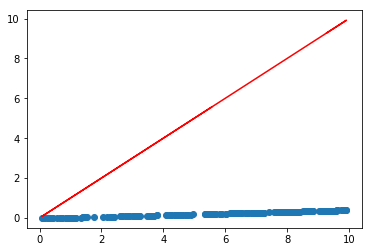

In [ ]:
for e in range(epoch):
    if e%100==0:        
        bidder = strat_to_bidder(model, batch_size)
        bidder.draw_valuations_()
        v = bidder.valuations.detach().cpu().numpy()[:plot_points]
        b = bidder.get_action().detach().cpu().numpy()[:plot_points]
        optimal = v
        share = (bidder.get_action() / bidder.valuations).mean()
        writer.add_graph(model, torch.cat((bidder.valuations,
                                           torch.zeros_like(bidder.valuations)+2),
                                          dim=1))
        print("Epoch {}: \tavg bid: {:2f}, \tutility: {:2f} ".format(
            start_epoch + e, share.item(),-es.step().item())
             )
        plt.plot(v,b, 'o', v, optimal, 'r-')
        plt.show()
    else: es.step()    

In [25]:
model.forward(torch.tensor([[5.,2]], device='cuda'))

tensor([[5.3119]], device='cuda:0', grad_fn=<ReluBackward>)

# two truthful agents meet

In [64]:
del es

In [26]:
batch_size=500000
p1 = Bidder.uniform(0,10, strategy=TruthfulStrategy(1), batch_size=batch_size)
p2 = Bidder.uniform(0,10, strategy=TruthfulStrategy(1), batch_size=batch_size)

p1.draw_valuations_()
p2.draw_valuations_()
b1 = p1.get_action()
b2 = p2.get_action()

bids = torch.cat((b1,b2), 1).view(batch_size, n_players, 1)
    
    # run the auction and calculate utilities
alloc, pay = mechanism.run(bids)
    
u1 = p1.get_utility(alloc[:,0,:], pay[:,0]).mean()
u2 = p2.get_utility(alloc[:,1,:], pay[:,1]).mean()
print("utilities: {:.4f}, {:.4f}".format(u1.item(), u2.item()))

utilities: 1.6639, 1.6645


In [27]:
2**19

524288

In [31]:
es.environment.agents[0].valuations[:10]

tensor([[5.3736],
        [6.8052],
        [3.2270],
        [7.0399],
        [4.6015],
        [5.9156],
        [4.5985],
        [4.1626],
        [3.1723],
        [6.6820]], device='cuda:0')